In [10]:
%pylab inline
figsize(12, 4)

Populating the interactive namespace from numpy and matplotlib


In [1]:
#! /usr/bin/env python

# =-=-=-=-=-=-=-=-=-=-=
# Load the corpus from a small collection of files
# =-=-=-=-=-=-=-=-=-=-= 

import glob

file_list = glob.glob('../texts/tentexts' + '/*.txt')

corpus = []

for file in file_list:
    with open(file) as f_input:
        corpus.append(f_input.read().replace('\n', ' '))
        
# =-=-=-=-=-=-=-=-=-=-=
# Glean the filenames from the glob list
# =-=-=-=-=-=-=-=-=-=-= 

filenames = [s.replace('../texts/tentexts/', '') for s in file_list]
docs = [s.replace('.txt', '').upper() for s in filenames]
print(docs)

['ANC-088', 'ANC-089', 'ANC-090', 'ANC-091', 'LAU-013', 'LAU-014', 'LOH-157', 'LOH-158', 'LOH-159', 'LOH-160']


## Setting up Concreteness Vocabulary

In [8]:
import math, re

# Set up a dictionary where k = word and v = weight
concretes = open('../metrics/Concreteness_Brysbaert_et_al.txt')
concrete_dict = dict(map(lambda wns: (wns[0], float(wns[2])), 
                 [ ws.strip().split('\t') for ws in concretes ]))

# Word splitter pattern
pattern_split = re.compile(r"\W+")

# Function to 
def concreteness(text):
    """
    Returns a single float for concreteness strength based on the input text.
    The higher the number, the more concrete.
    """
    words = pattern_split.split(text.lower())
    concretions = []
    for word in words:
        concretions.append(concrete_dict.get(word,0))
    if len(concretions) > 0:
        concreteness = sum(concretions)/math.sqrt(len(concretions))
        # Should we weight the individual word concreteness? 
        # I've seen N, sqrt(N) or 1.    
    else:
        concreteness = 0
    return concreteness

def concrete_line(text):
    """
    Returns a list of numbers, one for each sentence, of concreteness.
    """
    from nltk import tokenize
    sentences = tokenize.sent_tokenize(text.replace('\n', ' '))
    concretes = [ concreteness(sentence) for sentence in sentences ]
    return concretes

In [5]:
concrete_score = [ int(concreteness(text)) for text in corpus ]
print(concrete_score)

[42, 32, 30, 30, 41, 67, 47, 31, 40, 65]


## The Rise and Fall of Concreteness within a Text

In [24]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.interpolate import spline

In [6]:
def plotter (text, title, use_cuml=True):
    fig = plt.figure()
    sent, cuml = senticuml(text, method=method)
    if use_cuml == True:
        plt.plot(cuml,label=title)
        plt.ylabel("Cumulative Emotional Valence")
        plt.xlabel("Sentence #")
    else:
        plt.plot(sent,label=title)
        plt.ylabel("Emotional Valence")
        plt.xlabel("Sentence #")
    plt.legend()

In [36]:
text = corpus[4]
line = concrete_line(text)
print(len(line), line)

37 [7.1866666666666674, 6.7198400278578054, 4.6550000000000002, 4.4229529163218535, 9.0498710856379958, 11.17220230517807, 6.179719133700865, 6.8633333333333333, 7.1402626002129645, 7.1813249871753166, 6.6786322380730452, 8.7420750925096105, 7.2831495018753172, 8.332074904981484, 1.5383154051475549, 3.9667845920846272, 8.2185810819143228, 5.3289429846202463, 6.4333333333333327, 5.1196626309304261, 12.3825, 7.915, 3.3676634545122144, 4.3513882842145906, 4.7766666666666664, 1.5800000000000001, 3.2066666666666666, 6.1900000000000004, 2.3405234457274724, 4.0741158550046173, 8.39335749268432, 7.7789926901063007, 5.5533333333333337, 7.9655578900664574, 8.7920708078875887, 7.9813733813568426, 1.3279056191361391]


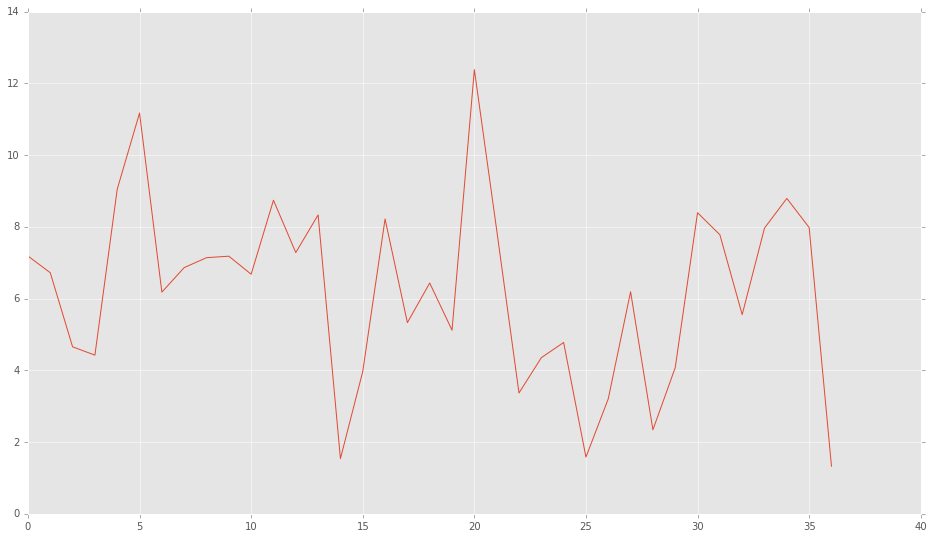

In [37]:
from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.rcParams["figure.figsize"] = (16,9)

plt.plot(line)
plt.show()

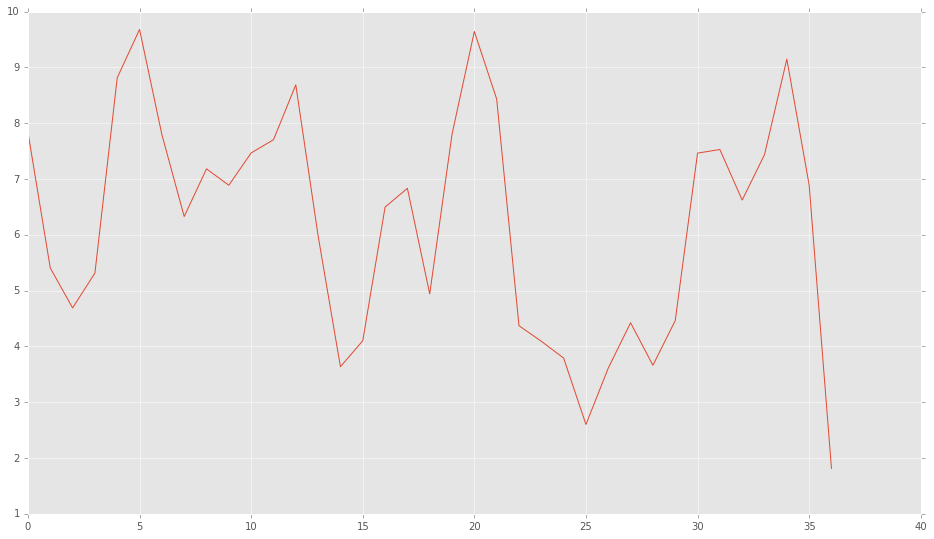

In [38]:
plt.plot(savgol_filter(line, 5, 2))
plt.show()

In [32]:
def movingaverage(values, window):
    from numpy import convolve
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

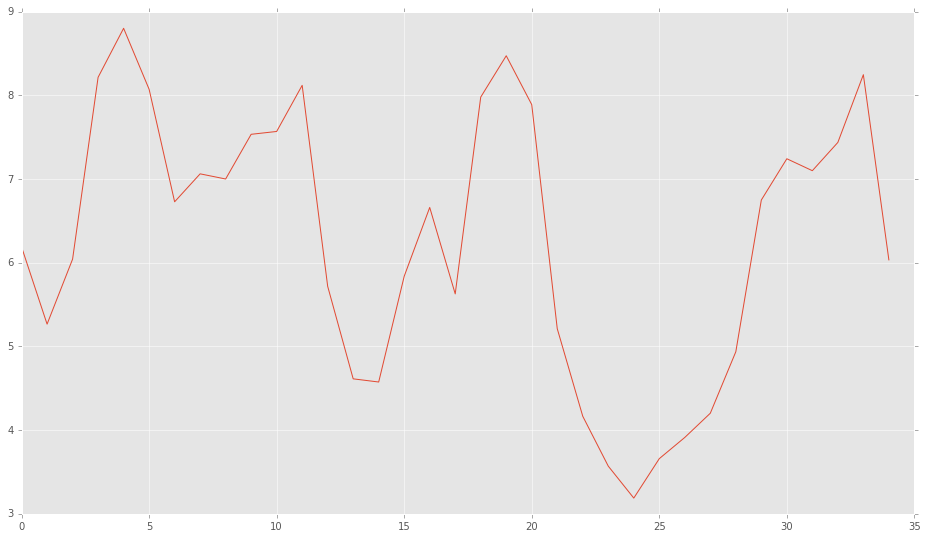

In [39]:
plt.plot(movingaverage(line, 3))
plt.show()

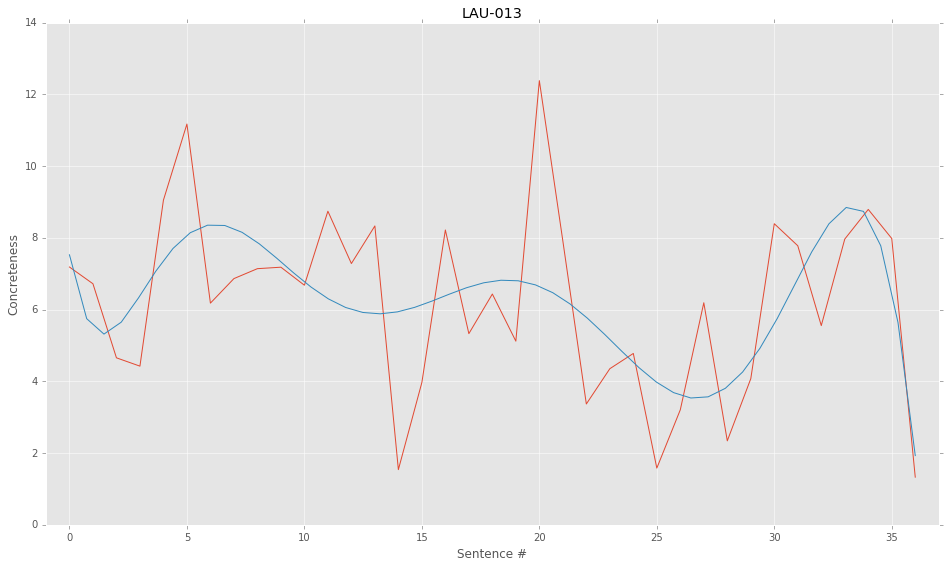

In [71]:
# Polynomial Fit
# https://stackoverflow.com/questions/19165259/ \
# python-numpy-scipy-curve-fitting

x = range(len(line))
y = line

z = np.polyfit(x, y, 8)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

plt.plot(x,y, x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.xlabel("Sentence #")
plt.ylabel("Concreteness")
plt.title('LAU-013')
plt.show()

In [68]:
def polyfit(line):
    x = range(len(line))
    y = line
    z = np.polyfit(x, y, 8)
    f = np.poly1d(z)
    # calculate new x's and y's
    x_new = np.linspace(x[0], x[-1], 50)
    y_new = f(x_new)
    return x_new, y_new

def comp_plot(text):
    fig = plt.figure()
    x = range(len(text))
    plt.title("Comparison")
    plt.plot((text), label = "Raw Data")
    plt.plot(savgol_filter(text, 5, 2), label = "Savitzky-Golay Filter")
    plt.plot(movingaverage(text, 3), label = "Moving Average")
    plt.plot(polyfit(text), label = "Polynomial Fit")
    plt.ylabel("Concreteness")
    plt.xlabel("Sentence #")
    plt.legend(loc='upper right')
    plt.show()

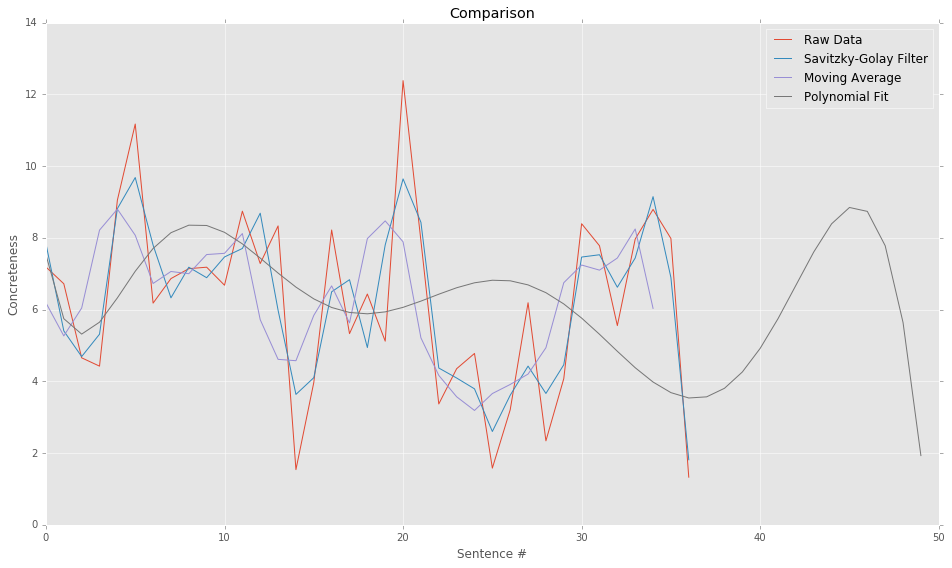

In [69]:
comp_plot(line)